In [1]:
import pandas as pd
import os
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statistics as st

In [2]:
def c_mean_cal(a):
    """
    
    Parameters
    ----------
    a : np.ndarray, shape=(d.n_frames,3)
        principal moment array of the input trajectory
        a[0]<=a[1]<=a[2]

    Returns
    -------
    .. math::
        
        \frac{a_1a_2+a_2a_3+a_3a_1}{(a_1+a_2+a_3)^2}

    """
    return (a[:,0]*a[:,1]+a[:,1]*a[:,2]+a[:,2]*a[:,0])/(a[:,0]+a[:,1]+a[:,2])**2
def calc_asphericity(d):
    """

    Parameters
    ----------
    d : mdtraj trajectory object. (Only Protein Atoms should be selected)
        target trajectory.

    Returns
    -------
    result : np.ndarray, shape=(d.n_frames,)
        asphericity array
    
    Reference
    -------
    
    Calculate the protein asphericity based on https://openscholarship.wustl.edu/etd/900/

    """
    # Calculate the principal axis

    p_m=md.principal_moments(d)
    result=1-3*c_mean_cal(p_m)
    
    return result

In [3]:
def average_asphericity(t):
    u=t.top.select('protein')
    r=t.atom_slice(u)
    j = r.n_frames
    d = calc_asphericity(r)
    return st.mean(d)

In [4]:
# Pyplot Setup
sns.set_theme(style="ticks", palette="pastel")
import matplotlib as mpl
plt.style.use(r'F:\DATA_F\JPCB_fig\publish.mplstyple')

In [5]:
def save_to_svg(filename, root_path='F:\DATA_F\JPCB_fig_publish'):
    plt.savefig(os.path.join(root_path,filename))

In [6]:
from scipy.spatial.transform import Rotation as R

In [7]:
prefix_20="F:\DATA_F\puma_scrammble_sum\puma_scramble_20-summary\BB\S_0"
prefix_GS16='F:\DATA_F\GSlinker_entropic_force\GS16-summary\BB\S_0'

In [8]:
def get_xyz_alpha(traj):
    u=traj.top.select('protein')
    r=traj.atom_slice(u)
    r_alpha=traj.topology.select_atom_indices(selection='alpha')
    return r.xyz[:,r_alpha,:]

In [9]:
traj_20=md.load([os.path.join(prefix_20, "".join(["__traj_",str(x),".xtc"])) for x in range(1)],
                top=os.path.join(prefix_20,"__START_0.pdb"))

In [10]:
xyz_np_20=get_xyz_alpha(traj_20)

In [11]:
def align(traj_xyz):
    result=np.zeros_like(traj_xyz)
    for index, i in enumerate(traj_xyz):
        objectframe=i[:,:]
        object_ori=objectframe[:,:]-objectframe[0,:]
        a1a2=object_ori[1,:]
        az=[0,0,1]
        normal_vec=np.cross(a1a2,az)
        angle=np.arccos(np.dot(a1a2,az)/np.linalg.norm(a1a2))
        unit_normal_vec=normal_vec/np.linalg.norm(normal_vec)
        rot_vec=angle*unit_normal_vec
        r=R.from_rotvec(rot_vec)
        result[index]=r.apply(object_ori)
    return result

In [12]:
xyz_plot_20=align(xyz_np_20)

In [28]:
def contor_map(input_np):
    reshape_np=input_np.reshape(-1,3)
    fig, ax = plt.subplots()
    counts,ybins,xbins,image=ax.hist2d(reshape_np[:,0],reshape_np[:,2],bins=np.linspace(-5,5,26),norm=mpl.colors.LogNorm(vmin=100,vmax=40000), cmap='Greys',range=[[-5,5],[-5,5]])
    fig.colorbar(image, ax=ax)
    #plt.contour(counts,extent=[xbins.min(),xbins.max(),ybins.min(),ybins.max()],linewidths=3)
    #plt.plot([-10,10],[0,0],'--',c='black')
    #plt.plot([0,0],[-10,10],'--',c='black')
    plt.ylim(-7,7)
    plt.xlim(-7,7)
    plt.xlabel('X')
    plt.ylabel('Z')

In [29]:
def contor_map_ax(input_np,fig,ax,title):
    reshape_np=input_np.reshape(-1,3)
    counts,xbins,ybins,image=ax.hist2d(reshape_np[:,0],reshape_np[:,2],bins=np.linspace(-5,5,26),norm=mpl.colors.LogNorm(vmin=100,vmax=40000), cmap='Greys',range=[[-5,5],[-5,5]])
    ax.set_title(title,fontsize=40)
    ax.set_xlim(-7,7)
    ax.set_ylim(-7,7)
    #fig.colorbar(image, ax=ax)
    ax.plot([-10,10],[0,0],'--',c='black')
    ax.plot([0,0],[-10,10],'--',c='black')
    return image
    #plt.ylim(-5,5)
    #plt.xlim(-5,5)
    #plt.xlabel('X')
    #plt.ylabel('Z')

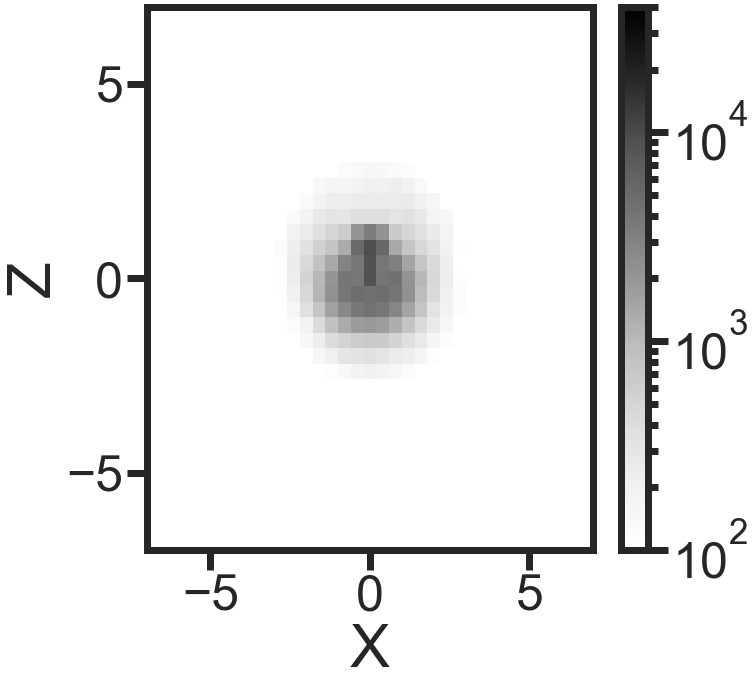

In [30]:
count=contor_map(xyz_plot_20)
#save_to_svg('colorbar.svg')

Average Asphericity: 0.40


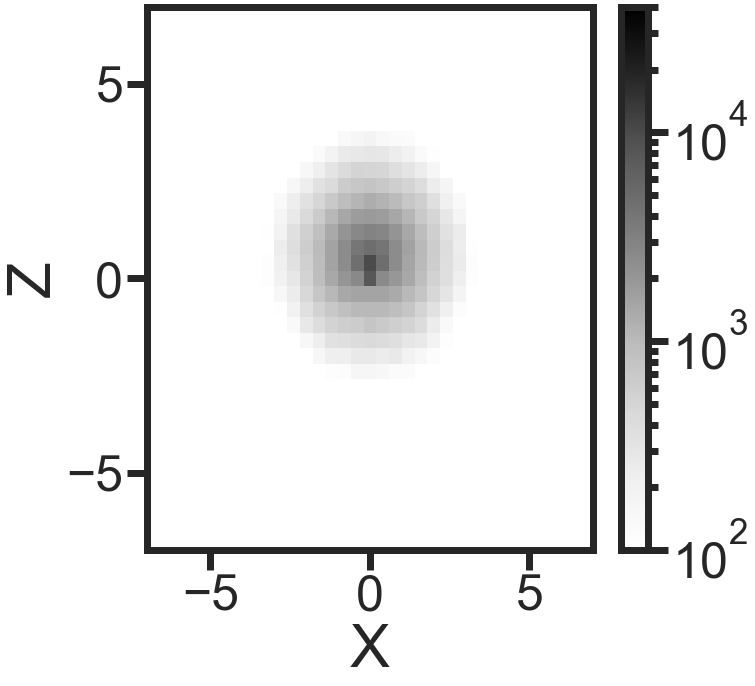

In [31]:
traj_GS16=md.load([os.path.join(prefix_GS16, "".join(["__traj_",str(x),".xtc"])) for x in range(1)],
                top=os.path.join(prefix_GS16,"__START_0.pdb"))
xyz_np_GS16=get_xyz_alpha(traj_GS16)
xyz_plot_GS16=align(xyz_np_GS16)
count=contor_map(xyz_plot_GS16)
print('Average Asphericity: {:.2f}'.format(average_asphericity(traj_GS16)))

Average Asphericity: 0.62


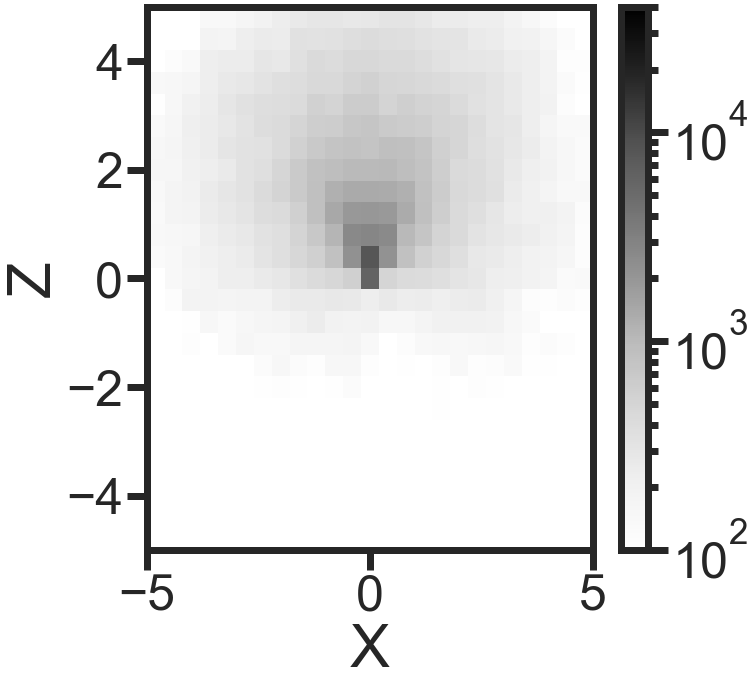

In [17]:
prefix_0720='F:\DATA_F\PDB_1009\DP00720-summary\BB\S_0'
traj_0720=md.load([os.path.join(prefix_0720, "".join(["__traj_",str(x),".xtc"])) for x in range(1)],
                top=os.path.join(prefix_0720,"__START_0.pdb"))
xyz_np_0720=get_xyz_alpha(traj_0720)
xyz_plot_0720=align(xyz_np_0720)
count=contor_map(xyz_plot_0720)
print('Average Asphericity: {:.2f}'.format(average_asphericity(traj_0720)))

Text(0.5, 0, 'X')

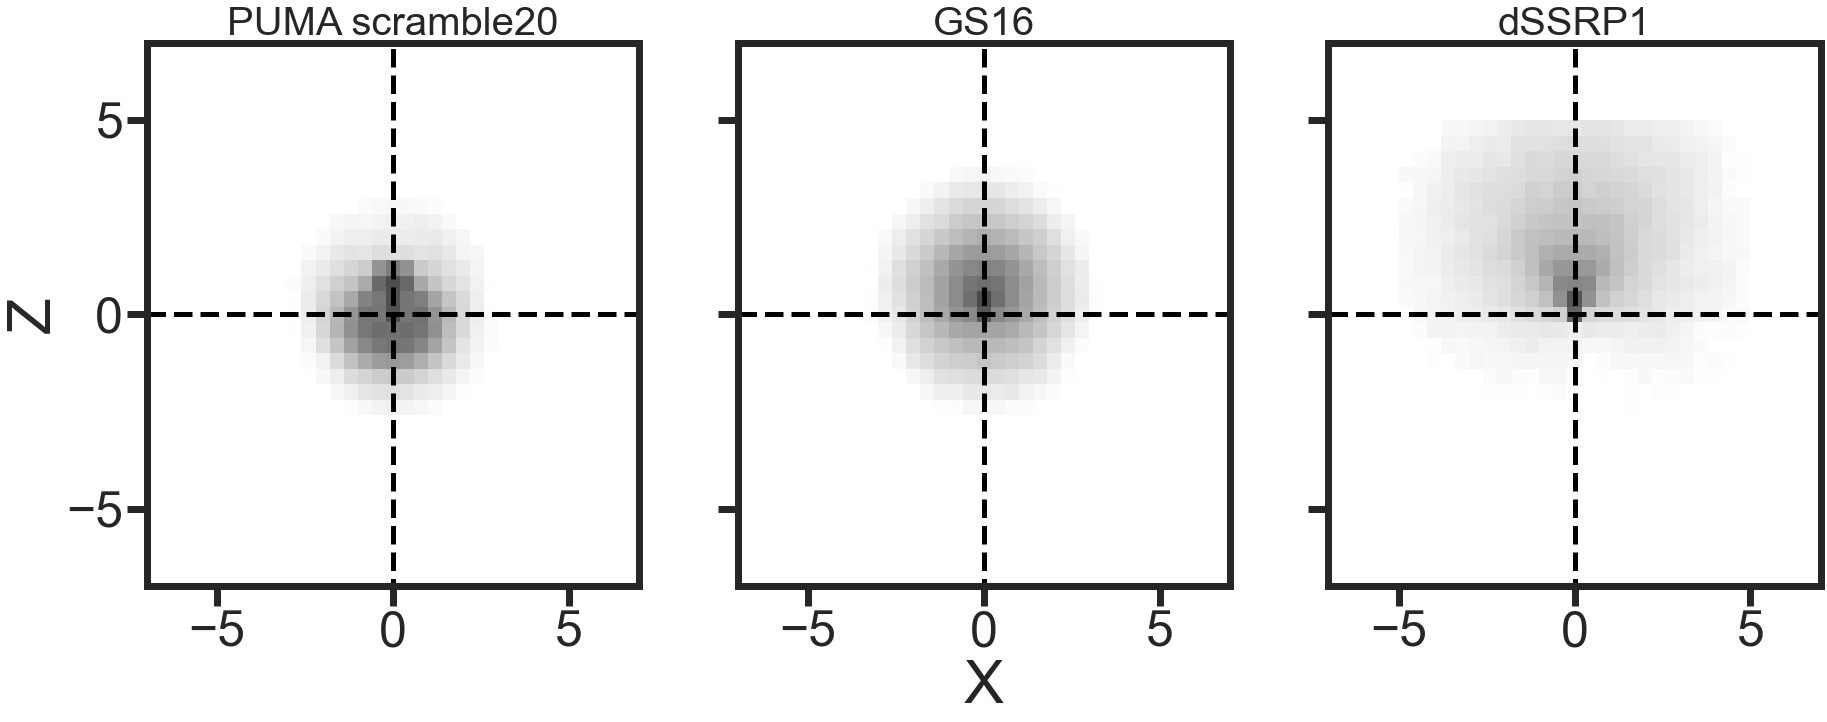

In [18]:
fig, axes = plt.subplots(1,3,figsize=(30,10),sharey=True)
contor_map_ax(xyz_plot_20,fig,axes[0],title='PUMA scramble20')
contor_map_ax(xyz_plot_GS16,fig,axes[1],title='GS16')
contor_map_ax(xyz_plot_0720,fig,axes[2],title='dSSRP1')
axes[0].set_ylabel('Z')
axes[1].set_xlabel('X')
#fig.suptitle('Points with z<=0')
#save_to_svg('Fig4D.svg')

In [19]:
prefix_1641='F:\DATA_F\PDB_1009\DP01641-summary\BB\S_0'
traj_1641=md.load([os.path.join(prefix_1641, "".join(["__traj_",str(x),".xtc"])) for x in range(1)],
                top=os.path.join(prefix_1641,"__START_0.pdb"))
xyz_np_1641=get_xyz_alpha(traj_1641)
xyz_plot_1641=align(xyz_np_1641)

In [20]:
prefix_0284='F:\DATA_F\PDB_1009\DP00284-summary\BB\S_0'
traj_0284=md.load([os.path.join(prefix_0284, "".join(["__traj_",str(x),".xtc"])) for x in range(1)],
                top=os.path.join(prefix_0284,"__START_0.pdb"))
xyz_np_0284=get_xyz_alpha(traj_0284)
xyz_plot_0284=align(xyz_np_0284)

In [21]:
prefix_GS24='F:\DATA_F\GSlinker_entropic_force\GS24-summary\BB\S_0'
traj_GS24=md.load([os.path.join(prefix_GS24, "".join(["__traj_",str(x),".xtc"])) for x in range(1)],
                top=os.path.join(prefix_GS24,"__START_0.pdb"))
xyz_np_GS24=get_xyz_alpha(traj_GS24)
xyz_plot_GS24=align(xyz_np_GS24)

In [22]:
prefix_Fibs='F:\DATA_F\PDB_1009\Fibs1NTD-summary\BB\S_0'
traj_Fibs=md.load([os.path.join(prefix_Fibs, "".join(["__traj_",str(x),".xtc"])) for x in range(1)],
                top=os.path.join(prefix_Fibs,"__START_0.pdb"))
xyz_np_Fibs=get_xyz_alpha(traj_Fibs)
xyz_plot_Fibs=align(xyz_np_Fibs)

In [23]:
prefix_41280='F:\DATA_F\PDB_1009\At2g41280_AtM-summary\BB\S_0'
traj_41280=md.load([os.path.join(prefix_41280, "".join(["__traj_",str(x),".xtc"])) for x in range(1)],
                top=os.path.join(prefix_41280,"__START_0.pdb"))
xyz_np_41280=get_xyz_alpha(traj_41280)
xyz_plot_41280=align(xyz_np_41280)

In [24]:
####
####
#### Use the second trajectory rather than the first one for better visualization
prefix_GS48='F:\DATA_F\GSlinker_entropic_force\GS48-summary\BB\S_0'
traj_GS48=md.load([os.path.join(prefix_GS48, "".join(["__traj_",str(x),".xtc"])) for x in range(1,2)],
                top=os.path.join(prefix_GS48,"__START_0.pdb"))
xyz_np_GS48=get_xyz_alpha(traj_GS48)
xyz_plot_GS48=align(xyz_np_GS48)

Text(0.5, 0, 'X')

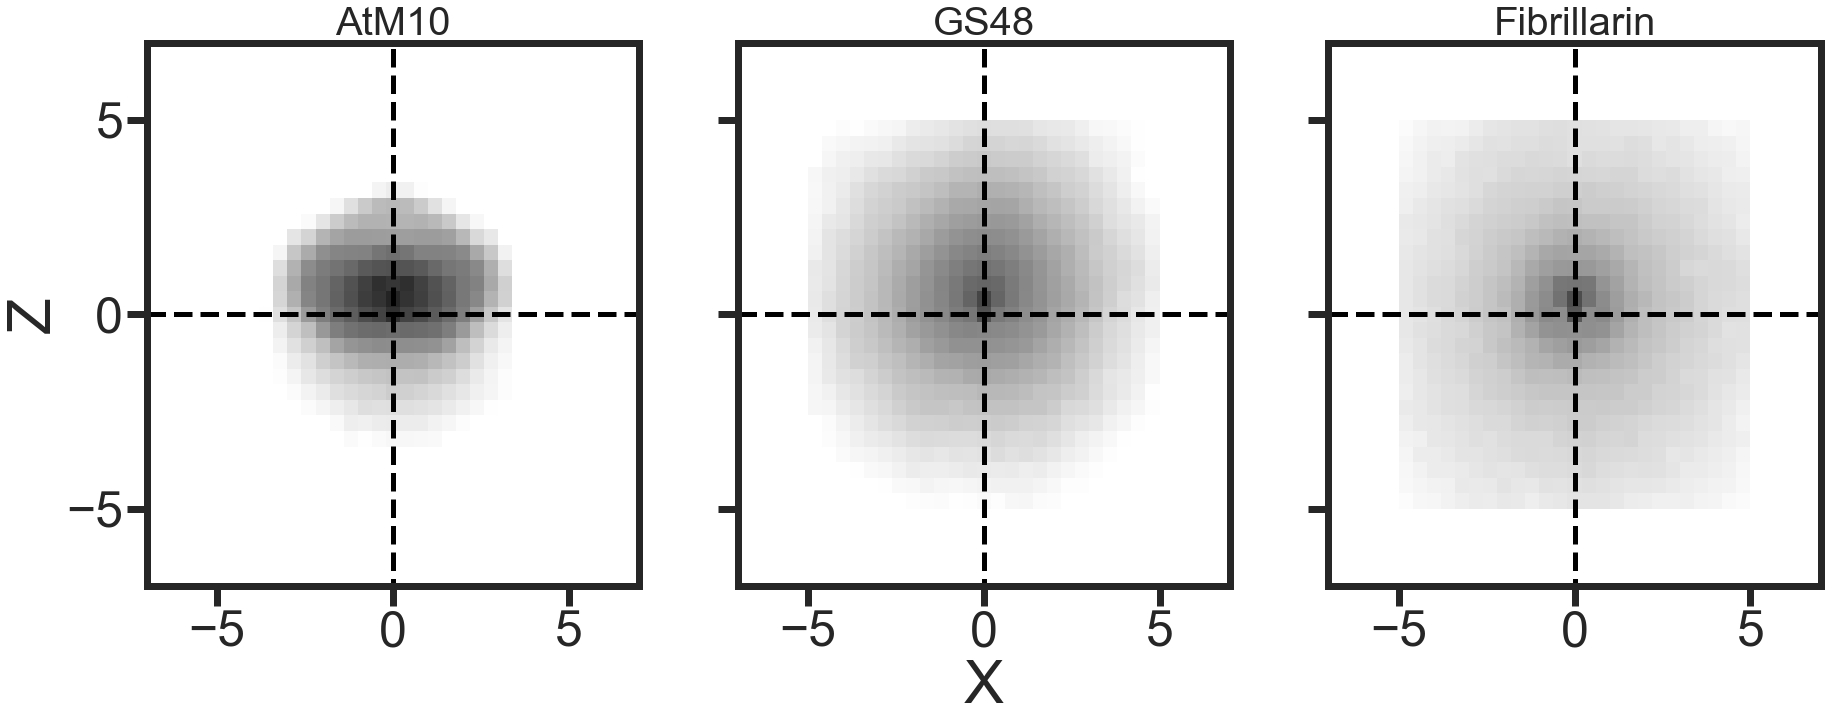

In [25]:
fig, axes = plt.subplots(1,3,figsize=(30,10),sharey=True)
contor_map_ax(xyz_plot_41280,fig,axes[0],title='AtM10')
contor_map_ax(xyz_plot_GS48,fig,axes[1],title='GS48')
contor_map_ax(xyz_plot_Fibs,fig,axes[2],title='Fibrillarin')
axes[0].set_ylabel('Z')
axes[1].set_xlabel('X')

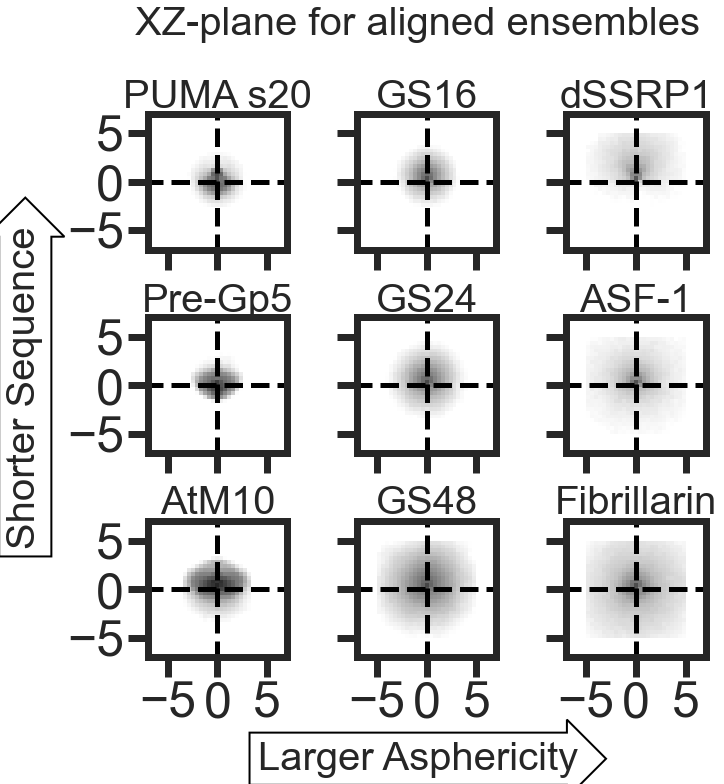

In [45]:
fig, axes = plt.subplots(3,3,figsize=(10,10),sharey=True,sharex=True)
axes_0=axes[0]
axes_1=axes[1]
axes_2=axes[2]

contor_map_ax(xyz_plot_20,fig,axes_0[0],title='PUMA s20')
contor_map_ax(xyz_plot_GS16,fig,axes_0[1],title='GS16')
contor_map_ax(xyz_plot_0720,fig,axes_0[2],title='dSSRP1')

contor_map_ax(xyz_plot_0284,fig,axes_1[0],title='Pre-Gp5')
contor_map_ax(xyz_plot_GS24,fig,axes_1[1],title='GS24')
image = contor_map_ax(xyz_plot_1641,fig,axes_1[2],title='ASF-1')

contor_map_ax(xyz_plot_41280,fig,axes_2[0],title='AtM10')
contor_map_ax(xyz_plot_GS48,fig,axes_2[1],title='GS48')
contor_map_ax(xyz_plot_Fibs,fig,axes_2[2],title='Fibrillarin')
#plt.tight_layout()
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.5)
fig.text(0.5, -0.03, 'Larger Asphericity', ha='center', fontsize=40,  bbox=dict(boxstyle="rarrow,pad=0.2", fc='white', ec="black", lw=2))
fig.text(-0.07, 0.5, 'Shorter Sequence', va='center', rotation='vertical', fontsize=40, bbox=dict(boxstyle="rarrow,pad=0.2", fc='white', ec="black", lw=2))
fig.text(0.5, 0.99, 'XZ-plane for aligned ensembles', ha='center', fontsize=40)
save_to_svg('Fig4D.svg')

In [27]:
dict_data={'PUMA s20': traj_20,
           'GS16': traj_GS16,
           'dSSRP1': traj_0720,
           'Pre-Gp5':traj_0284,
           'GS24':traj_GS24,
           'ASF-1':traj_1641,
           'AtM10':traj_41280,
           'GS48':traj_GS48,
           'Fibrillarin':traj_Fibs}
for name, traj in dict_data.items():
    print('Protein name {} Asphericity {:.2f}'.format(name,average_asphericity(traj)))

Protein name PUMA s20 Asphericity 0.27
Protein name GS16 Asphericity 0.40
Protein name dSSRP1 Asphericity 0.62
Protein name Pre-Gp5 Asphericity 0.19
Protein name GS24 Asphericity 0.40
Protein name ASF-1 Asphericity 0.65
Protein name AtM10 Asphericity 0.20
Protein name GS48 Asphericity 0.39
Protein name Fibrillarin Asphericity 0.56
